In [1]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from scipy.fft import fft, ifft, fftfreq, fftshift
from scipy.spatial.transform import Rotation as R

In [2]:
ZUPT_THRESH=70

def eulerToRotationMatrix(roll,pitch,yaw):
    # the rotation order is Z>>Y>>X
    Rx=np.array([[1, 0, 0],
                 [0, np.cos(roll), -np.sin(roll)],
                [0, np.sin(roll), np.cos(roll)]])
    
    Ry=np.array([[np.cos(pitch), 0, np.sin(pitch)],
                 [0, 1, 0],
                [-np.sin(pitch), 0, np.cos(pitch)]])
    
    Rz=np.array([[np.cos(yaw), -np.sin(yaw), 0],
                 [np.sin(yaw), np.cos(yaw), 0],
                [0, 0, 1]])
    return np.matmul(Rz, np.matmul(Ry, Rx))

def RotationMatrixToQuaternion(R):
    qw=np.sqrt(1+R[0][0]+R[1][1]+R[2][2])/2
    qx=(R[2][1]-R[1][2])/(4*qw)
    qy=(R[0][2]-R[2][0])/(4*qw)
    qz=(R[1][0]-R[0][1])/(4*qw)
    return np.array([qx,qy,qz,qw])

def quaternionMultiplication(Q1,Q2):
    qx1,qy1,qz1,qw1=Q1
    qx2,qy2,qz2,qw2=Q2
    
    qw=qw1*qw2-qx1*qx2-qy1*qy2-qz1*qz2
    qx=qw1*qx2+qx1*qw2+qy1*qz2-qz1*qy2
    qy=qw1*qy2-qx1*qz2+qy1*qw2+qz1*qx2
    qz=qw1*qz2+qx1*qy2-qy1*qx2+qz1*qw2
    
    return np.array([qx,qy,qz,qw])

def quaternionUpdate(Q,omega,DT):

#     S=np.array([omega[2],omega[1],-omega[0],0])
    S=np.array([omega[0],omega[1],omega[2],0])
    dQ=0.5*quaternionMultiplication(Q,S)
    
    return Q+DT*dQ

def quaternionToRotationMatrix(Q):
    qx,qy,qz,qw=Q
    r11=qw**2+qx**2-qy**2-qz**2
    r22=qw**2-qx**2+qy**2-qz**2
    r33=qw**2-qx**2-qy**2+qz**2
    
    r12=2*(qx*qy-qw*qz)
    r13=2*(qx*qz+qw*qy)
    
    r21=2*(qx*qy+qw*qz)
    r23=2*(qy*qz-qw*qx)
    
    r31=2*(qx*qz-qw*qy)
    r32=2*(qy*qz+qw*qx)
    R=np.array([[r11,r12,r13],
              [r21, r22, r23],
              [r31, r32, r33]])
    return R

def RotationMatrixToEuler(R):
    r31, r32, r33, r21, r11=R[2][0],R[2][1],R[2][2],R[1][0],R[0][0]
    
    pitch=-np.arcsin(r31)
    roll=np.arctan2(r32/np.cos(pitch),r33/np.cos(pitch))
    yaw=np.arctan2(r21/np.cos(pitch),r11/np.cos(pitch))
    return np.array([roll*57,pitch*57,yaw*57])

def quaternionConjugate(Q):
    return np.array([-Q[0], -Q[1], -Q[2], Q[3]])

def quaternionVectorRotation(Q,V):
    V_quat_before=np.array([V[0], V[1], V[2], 0])
    Q_tag=quaternionConjugate(Q)
    V_quat_after=quaternionMultiplication(quaternionMultiplication(Q,V_quat_before),Q_tag)
    return np.array([V_quat_after[0], V_quat_after[1], V_quat_after[2]])

def isZupt(df_g, i):
    return np.sqrt(np.sum(df_g.iloc[i,3:].values**2))<ZUPT_THRESH

## data analisys

###  raw data and time correlation if needed

acc
   epoch (ms)             time (03:00)  elapsed (s)  x-axis (g)  y-axis (g)  \
0 -1213792731  2024-04-07T11:22:38.373         0.00      -0.564       0.192   
1 -1213792711  2024-04-07T11:22:38.393         0.02      -0.570       0.195   
2 -1213792691  2024-04-07T11:22:38.413         0.04      -0.566       0.195   
3 -1213792671  2024-04-07T11:22:38.433         0.06      -0.567       0.197   
4 -1213792651  2024-04-07T11:22:38.453         0.08      -0.567       0.197   

   z-axis (g)  
0       0.843  
1       0.851  
2       0.849  
3       0.849  
4       0.849  
<class 'numpy.ndarray'>


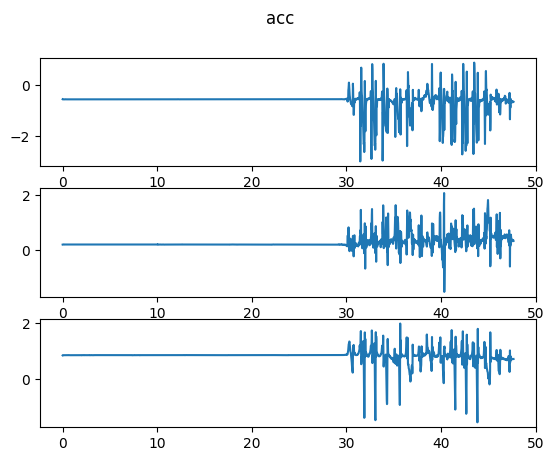

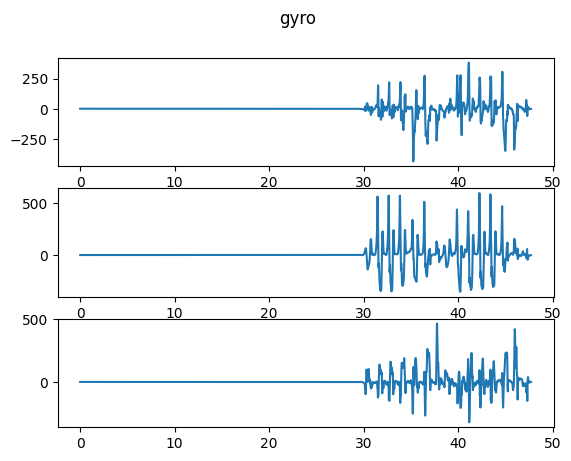

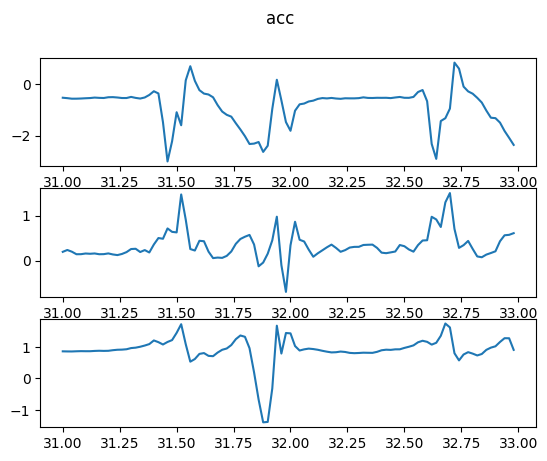

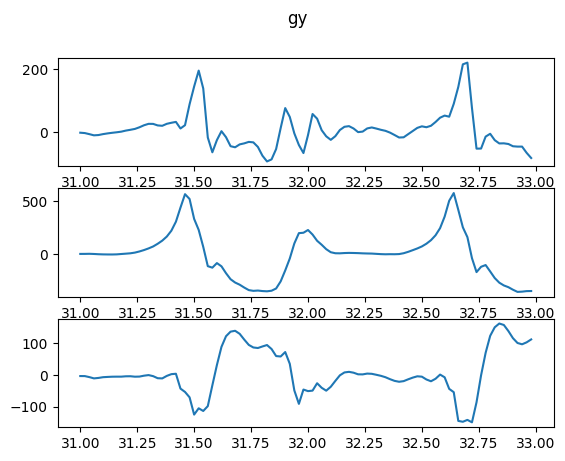

In [3]:
# files
files_location="C:\\Users\\vyoha\\GitHub\\tutorials\\scipy\\data\\navigation\\"
file_a='strightRightAndBack_MetaWear_2024-04-07T11.22.38.209_C3B38AD76217_Accelerometer_50.000Hz_1.7.3.csv'
file_g='strightRightAndBack_MetaWear_2024-04-07T11.22.38.209_C3B38AD76217_Gyroscope_50.000Hz_1.7.3.csv'

# load data
print("acc")

df_a=pd.read_csv(files_location+file_a, dtype={'epoch (ms)':np.int32,'time (03:00)':str,'elapsed (s)':np.float64,'x-axis (g)':np.float64,'y-axis (g)':np.float64,'z-axis (g)':np.float64})
print(df_a.head())
print(type(df_a.iloc[0,3:].values))
df_g=pd.read_csv(files_location+file_g)
# df_g.head()

# visualise data
fig_a,ax_a=plt.subplots(3)
for i in [0,1,2]:
    ax_a[i].plot(df_a.iloc[:,2],df_a.iloc[:,3+i])
fig_a.suptitle("acc")
plt.show()

fig_g,ax_g=plt.subplots(3)
for i in [0,1,2]:
    ax_g[i].plot(df_g.iloc[:,2],df_g.iloc[:,3+i])
fig_g.suptitle("gyro")
plt.show()

# focus on rigion
id0=50*31
id1=50*33
fig_a,ax_a=plt.subplots(3)
for i in [0,1,2]:
    ax_a[i].plot(df_a.iloc[id0:id1,2],df_a.iloc[id0:id1,3+i])
fig_a.suptitle("acc")
plt.show()

fig_g,ax_g=plt.subplots(3)
for i in [0,1,2]:
    ax_g[i].plot(df_g.iloc[id0:id1,2],df_g.iloc[id0:id1,3+i])
fig_g.suptitle("gy")
plt.show()

# Take 2

In [4]:
import sys
!{sys.executable} -m pip install filterpy
import scipy.spatial.transform as tr

from filterpy.kalman import KalmanFilter
from filterpy.common import Q_discrete_white_noise, Saver
kf = KalmanFilter(dim_x=3, dim_z=1)


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: C:\Users\vyoha\GitHub\tutorials\scipy\scipy_tutorial_venv\Scripts\python.exe -m pip install --upgrade pip


## Content
1. problem definition
    * the process and unmodeld possible dynamics and erroes
    * the measurement and possible errors
2. algorithm description
    * general description
    * states
    * control input and matrix
    * transition matrix
    * states covariance
    * process covariance
    * measurement covariance
    * measurement matrix
3. library vs my code
    * covariance
    * predict
    * update
4. sensor noise
    * sensor variance
    * datasheet errors?
5. experiment
6. analisys
    * states variance
    * states variance and residuals
    * total errors

## Problem definition
שילוב "מדידות" מהירות בחישוב קינמטיקה של הולך רגל לצורך הקטנת סחיפה.

שאלות: 
מי סוחף יותר ג'יירו? מד תאוצה?
איך מתבטאת הסחיפה בקואטרניונים

### the process and unmodeld possible dynamics and erroes
המודל הוא שלפי מצב קודם של אוריינטציה ומיקום ומהירות, נכניס כניסת בקרה של תאוצה בצירי עולם(בעזרת טרנספורמציה עם אוריינטציה מחושבת), נעשה אינטגרציה כפולה על התאוצה הקווית ונקבל העתק ברגה הדגימה.

בהמשך נוסיף קומפלמנטרי פילטר.

במצב זה בהנחה שהמדידות מושלמות(והן לא ונצתרך להתחשב בזה בשגיאת התהליך), בעייה נוספת היא תזוזה של החיישן עצמו, כנראה בעיקר מהלמים מהקרקע

### the measurement and possible errors
פה אי הוודאות תגיע ב2 מובנים:

האם הזיהוי הוא מדוייק של הזאפט

האם התנאי של אפס מהירות מדוייק

## algorithm description

### general description

אתחול

1. נתחיל עם אוריינטציה התחלתית ממד תאוצה(ואולי ממגנטומטר בהמשך) ומאתחול מהירות ומיקום ואי ודאות בכל אחד מהם

אוריינטציה

2. עדכון קואטרניון
3. נחשב המרה של מדידות תאוצה בעזרת קואטרניונים

קידום

4. נחסר כבידה בציר עולם ונעשה אינטגרציה בכל הצירים
5. נקבל מדידת ג'יירו ונקדם אוריינטציה עם קואטרניונים
6. נקדם אי ודאות בעזרת (קידום של אי ודאות וחיבור ךאי ודאות בתהליך)

עדכון

7. קבלת מדידה
8. חישוב הגבר
9. חישוב שיערוך
10. עדכון אי ודאות

##  Preprocessing
 

### states
X=[x,y,z,vx,vy,vz]


### orientation

we need a rotation from body to earth

will define w->b z-->y-->x

$S=(0,\omega_{x}, \omega_{y}, \omega_{z})$

$dQ=0.5*Q_{old}*S$

$Q_{new}=Q_{old}+dQ*DT$


$V_{a}=[0, x_{a}, y_{a}, z_{a}]$

$V_{b}=[0, x_{b}, y_{b}, z_{b}]$

$V_{b}=Q\bigotimes v_{A}\bigotimes Q^{*}$


### control input and matrix

U=[a_linear_x, a_linear_y, a_linear_z]
U2=[gx, gy, gz]

a_linear=a*R-g

G=[0,0,0,
    0,0,0,
    0,0,0,
    dt,0,0,
    0,dt,0,
    0,0,dt]

In [5]:
# G=np.array([0,0,0],
#           [0,0,0],
#           [0,0,0])

### transition matrix

### states covariance

### process covariance

### measurement covariance

### measurement matrix

## library vs my code

### covariance 

### predict 

### update 

## sensor noise

### sensor variance 

### datasheet errors?

## experiment

In [6]:
## simulate mag
# 0-1600 : 0 deg
# 1600-1800: 90 deg
# 1800-2000: -90 deg
# 2000- len: -180 deg
    
yaw1=np.ones((1600,1))*0
yaw2=np.ones((200,1))*90
yaw3=np.ones((200,1))*-90
yaw4=np.ones((len(df_a)-2000,1))*-180
yaw_mes=np.concatenate((yaw1,yaw2,yaw3,yaw4))
print(np.shape(yaw_mes))
print(len(df_a))

(2384, 1)
2384


init= 33.80120777377941 12.837210053576444
u= [2.49699465 2.24575764 1.17614217] acc ang= -41.75106356511162
u= [3.9358971  2.31686584 0.92342425] acc ang= -30.325830330360578
u= [ 8.09360755  6.11307108 -1.29248762] acc ang= -36.872278150550855
u= [ 9.56356453  6.45742052 -1.55497341] acc ang= -33.851978486695636
u= [ 9.58386413 -1.78186193 -1.59488026] acc ang= 10.47797890670544
u= [ 8.79704329 -2.29300517 -0.20598842] acc ang= 14.534016604133477
u= [ 7.52735539 -2.42439346  1.06214899] acc ang= 17.760432211897093
u= [ 6.24662702 -2.10028637  1.38628437] acc ang= 18.488111632535507
u= [ 5.23494409 -0.60324197  1.61464794] acc ang= 6.539477088074971
u= [4.19654392 1.25255994 1.87144502] acc ang= -16.533212432168973
u= [2.89851781 1.98749931 1.8742786 ] acc ang= -34.26045817008266
u= [2.05173971 2.52367269 1.59744873] acc ang= -50.626268258070944
u= [1.0127323  2.52542722 1.88124759] acc ang= -67.79670642289895
u= [-0.48971653  1.49770293  1.98912649] acc ang= 71.52223547201359
u= [-1.

u= [ -4.72005811   8.08421738 -10.40823488] acc ang= 59.4127173024848
u= [-1.85916147  6.73095517 -8.69183861] acc ang= 74.17438141008643
u= [-2.46294225  5.62580367 -9.22020616] acc ang= 66.0139383725611
u= [-4.69910147  5.28872152 -7.30134982] acc ang= 48.128726280445015
u= [-5.14536195  4.42533981 -3.89188398] acc ang= 40.48753948422981
u= [-5.91657976  3.23491939 -1.11635395] acc ang= 28.519859528232274
u= [-8.23077937  1.15092721  2.09847828] acc ang= 7.919082435446056
u= [-9.07934323 -1.80080683  3.89816718] acc ang= -11.16059694786262
u= [-8.98558304 -4.33536138  4.42403028] acc ang= -25.623402830161442
u= [-8.18900403 -7.40990852  6.2874946 ] acc ang= -41.923165444538995
u= [ -5.39196843 -10.51386402   6.8781931 ] acc ang= -62.52482011630771
u= [ -1.28165589 -12.06586188   4.95197628] acc ang= -83.50337460329672
u= [  1.04590174 -12.8186594    2.88798624] acc ang= 84.8949185830153
u= [  1.49905443 -12.95632668   2.20714672] acc ang= 82.96965177075087
u= [  2.28833768 -10.789108

u= [21.37811678  3.95832657 -4.83772082] acc ang= -10.43581123422862
u= [ 22.57554963   1.74301373 -13.26294642] acc ang= -4.392144263998663
u= [ 24.55684169   0.76295659 -19.53619247] acc ang= -1.7703636913042742
u= [ 18.99409106  -1.77149438 -19.62650378] acc ang= 5.300802333971518
u= [-6.23609716  1.56566381  5.99834822] acc ang= 14.020887071773162
u= [ 6.02671351  0.20258226 -2.87916229] acc ang= -1.9152797921207396
u= [10.82373833  2.01419513  6.15518447] acc ang= -10.487201729768945
u= [17.69298402  1.22305861 10.47403227] acc ang= -3.933966948023822
u= [4.26251833 4.73151734 1.68458106] acc ang= -47.737302440171554
u= [2.55465907 0.02521485 1.23118132] acc ang= -0.5625799712300273
u= [3.40411874 0.26254356 1.90432251] acc ang= -4.387454625062458
11 10 38.93062831554756 31.641274792831695
########################### u= 0.0 ,x= 0.9896951027231652  vx= 0.46799678753439045
u= [-0.27700076  2.44010471  0.90076944] acc ang= 83.0923311488454
u= [-1.13399131  3.17478865  1.08812905] acc

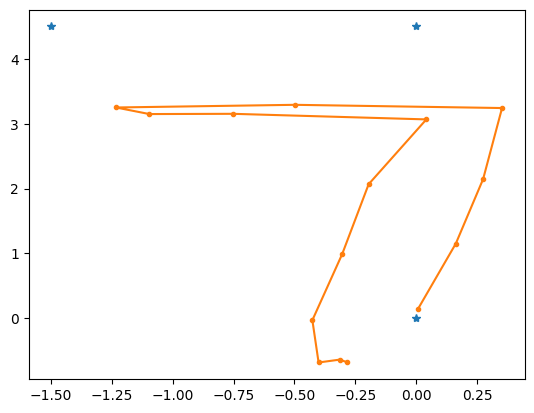

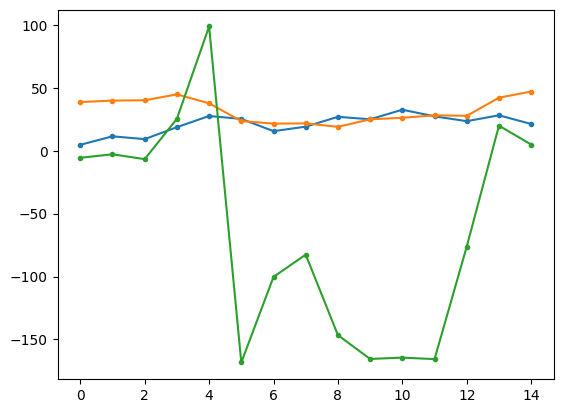

In [7]:
from filterpy.stats import plot_covariance_ellipse
# from kf_book.book_plots import plot_filter

R_std = .1
Q_std = 1


tracker = KalmanFilter(dim_x=6, dim_z=3, dim_u=3)
dt = 0.02  # time step

tracker.F = np.array([[1, 0, 0, dt, 0,  0],
                      [0,  1, 0,  0, dt, 0],
                      [0,  0, 1, 0, 0, dt],
                      [0,  0, 0,  1, 0, 0],
                     [0,  0, 0,  0, 1, 0],
                     [0,  0, 0 ,0 , 0, 1]])
tracker.B = np.array([[0,0,0],
            [0,0,0],
            [0,0,0],
            [dt,0,0],
            [0,dt,0],
            [0,0,dt]])

tracker.H = np.transpose(np.array([[0,0,0],
                          [0, 0, 0],
                          [0, 0, 0],
                          [1, 0, 0],
                          [0, 1, 0],
                          [0, 0, 1]]))

tracker.R = np.eye(3) * R_std**2
q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_std**2, block_size=3, order_by_dim=False)
tracker.Q = q

tracker.x = np.array([0, 0, 0, 0, 0, 0]).T
tracker.P *= 50.


# simulate robot movement

i=0
pitch=np.arctan2(-df_a.iloc[i,3],df_a.iloc[i,5])*180/3.14
roll=np.arctan2(df_a.iloc[i,4],df_a.iloc[i,5])*180/3.14
print("init=",pitch,roll)
rot=tr.Rotation.from_euler('ZYX', [0,pitch,roll], degrees=True)
QQ=rot.as_quat()
a=df_a.iloc[0,3:6].values
a_bias=np.mean(df_a.iloc[0:100,3:6].values)

N = 30
sensor = np.array([0., 0., 0.])


# run filter
f = tracker
s = Saver(f)

ang=[]
uu=[]
zupt_vec=[]
x_est, ang_est=[],[]
started=False
j=0
step_ind=0
for i in range(df_a.shape[0]):
    
    omega=df_g.iloc[i,3:].values*3.14/180
    QQ=quaternionUpdate(QQ,omega,dt)

    QQ=QQ/np.linalg.norm(QQ)
    RR=quaternionToRotationMatrix(QQ)
    ang.append(RotationMatrixToEuler(RR))
        
    # check zupt
    if(isZupt(df_g, i)):

        # if 1st in this step
        if(len(zupt_vec)>0):
            if(zupt_vec[-1]==0 or step_ind>0):
                step_ind=step_ind+1
                if(step_ind==10):
                    u=u*0.
                    uu.append(u)
                    f.predict(u=np.array(u))
                    j=j+1
                    zupt_vec.append(1)
                    pitch=np.arctan2(-df_a.iloc[i,3],df_a.iloc[i,5])*180/3.14
                    roll=np.arctan2(df_a.iloc[i,4],df_a.iloc[i,5])*180/3.14

                    print(j,step_ind,pitch,roll)
        
                    f.update(sensor)
                    x_est.append(f.x)
                    ang_est.append(ang[-1])
                    print("########################### u=",u[0],",x=",x_est[-1][0]," vx=",x_est[-1][3])
    else:
        step_ind=0
        zupt_vec.append(0)
        a=df_a.iloc[i,3:6].values
    
        # calculate linear acc
        u=quaternionVectorRotation(QQ,a)-np.array([0,0,1])
        u=u*9.8
        uu.append(u)
        f.predict(u=np.array(u))
        print("u=",u,"acc ang=",np.arctan(-u[1]/u[0])*57)
#   
# if(i%50==0):
#             P=tracker.P
#             x=tracker.x
#             cov = np.array([[P[0, 0], P[3, 0]], 
#                             [P[0, 3], P[3, 3]]])
#             mean = (x[0], x[3])
#             plot_covariance_ellipse(mean, cov=cov, fc='g', std=3, alpha=0.5)
#             plt.plot(i*dt,x[1],'*')
    s.save()
    

plt.show()    
plt.plot([0,0,-1.5],[0,4.5,4.5],'*')
x=np.array(x_est)
plt.plot(-x[:,1],x[:,0],'.-')
plt.show()

# plot results
# zs *= .3048 # convert to meters
# plot_filter(mu[:, 0], mu[:, 2])
# plot_measurements(zs[:, 0], zs[:, 1])
# plt.legend(loc=2)
# plt.xlim(0, 20);
ang_est=np.array(ang_est)
plt.plot(ang_est[:,0],'.-')
plt.plot(ang_est[:,1],'.-')
plt.plot(ang_est[:,2],'.-')
plt.show()

### with pitch update

In [31]:
for i in range(df_a.shape[0]):
    
    omega=df_g.iloc[i,3:].values*3.14/180
    QQ=quaternionUpdate(QQ,omega,dt)

    QQ=QQ/np.linalg.norm(QQ)
    RR=quaternionToRotationMatrix(QQ)
    ang=RotationMatrixToEuler(RR)
    print(i,",mes=",(ang))
    qq=np.array([0,np.sin(-ang[1]/57/2),0,np.cos(-ang[1]/57/2)])
    QQ2=quaternionMultiplication(QQ,qq)
    QQ2=QQ2/np.linalg.norm(QQ2)
    print("rotate to zero pitch")
    RR2=quaternionToRotationMatrix(QQ2)
    ang2=RotationMatrixToEuler(RR2)
    print("mes after=",(ang2))
    qq3=np.array([0,np.sin(pitch/57/2),0,np.cos(pitch/57/2)])
    QQ23=quaternionMultiplication(QQ2,qq3)
    QQ23=QQ23/np.linalg.norm(QQ23)
    print("pitch0=",pitch)
    RR23=quaternionToRotationMatrix(QQ23)
    ang3=RotationMatrixToEuler(RR23)
    print("mes after=",(ang3))
    print()

0 ,mes= [-5.48269425  2.06502755 73.38073429]
rotate to zero pitch
mes after= [-5.47908555e+00  9.53716407e-03  7.35790152e+01]
pitch0= 42.270975415011954
mes after= [-7.41241213 42.03990415 68.57987846]

1 ,mes= [-5.48420435  2.07398825 73.37255187]
rotate to zero pitch
mes after= [-5.48056326e+00  9.58374850e-03  7.35717475e+01]
pitch0= 42.270975415011954
mes after= [-7.41440654 42.0398211  68.57126981]

2 ,mes= [-5.48682351  2.07835189 73.36725221]
rotate to zero pitch
mes after= [-5.48316534e+00  9.61304524e-03  7.35669618e+01]
pitch0= 42.270975415011954
mes after= [-7.4179122  42.03962225 68.5641271 ]

3 ,mes= [-5.48943447  2.08030035 73.36218572]
rotate to zero pitch
mes after= [-5.48576767e+00  9.63119406e-03  7.35621773e+01]
pitch0= 42.270975415011954
mes after= [-7.42141688 42.03941216 68.55698626]

4 ,mes= [-5.49075289  2.08489688 73.35930223]
rotate to zero pitch
mes after= [-5.48706898e+00  9.65707026e-03  7.35597835e+01]
pitch0= 42.270975415011954
mes after= [-7.42317138 4

157 ,mes= [-5.83514742  2.45828341 72.81315425]
rotate to zero pitch
mes after= [-5.82970270e+00  1.28539895e-02  7.30642948e+01]
pitch0= 42.270975415011954
mes after= [-7.88450062 42.01152397 67.74784715]

158 ,mes= [-5.83905244  2.45887009 72.80699085]
rotate to zero pitch
mes after= [-5.83360145e+00  1.28742487e-02  7.30583588e+01]
pitch0= 42.270975415011954
mes after= [-7.88974558 42.01118091 67.73838691]

159 ,mes= [-5.84285874  2.46091126 72.80311889]
rotate to zero pitch
mes after= [-5.83739512e+00  1.29016988e-02  7.30548589e+01]
pitch0= 42.270975415011954
mes after= [-7.89485009 42.01085457 67.73145706]

160 ,mes= [-5.84672276  2.46403472 72.79791466]
rotate to zero pitch
mes after= [-5.84124162e+00  1.29351098e-02  7.30501400e+01]
pitch0= 42.270975415011954
mes after= [-7.90002633 42.010529   67.72326022]

161 ,mes= [-5.84931093  2.46486871 72.7941668 ]
rotate to zero pitch
mes after= [-5.84382363e+00  1.29509253e-02  7.30465888e+01]
pitch0= 42.270975415011954
mes after= [-7.

287 ,mes= [-6.22582415  2.80986778 72.22969354]
rotate to zero pitch
mes after= [-6.21823114e+00  1.67172280e-02  7.25358689e+01]
pitch0= 42.270975415011954
mes after= [-8.40714359 41.977992   66.86836495]

288 ,mes= [-6.23098711  2.81161803 72.22339204]
rotate to zero pitch
mes after= [-6.22337828e+00  1.67553349e-02  7.25300110e+01]
pitch0= 42.270975415011954
mes after= [-8.41406191 41.97751877 66.85786179]

289 ,mes= [-6.23736335  2.81336764 72.21709036]
rotate to zero pitch
mes after= [-6.22973720e+00  1.68000239e-02  7.25242127e+01]
pitch0= 42.270975415011954
mes after= [-8.42260852 41.97693118 66.84632495]

290 ,mes= [-6.2413004   2.81270503 72.21105388]
rotate to zero pitch
mes after= [-6.23367299e+00  1.68172690e-02  7.25182970e+01]
pitch0= 42.270975415011954
mes after= [-8.42789689 41.97655681 66.83685846]

291 ,mes= [-6.24525061  2.81445364 72.2047519 ]
rotate to zero pitch
mes after= [-6.23760884e+00  1.68489764e-02  7.25123796e+01]
pitch0= 42.270975415011954
mes after= [-8.

455 ,mes= [-6.61997595  3.27989604 71.50647699]
rotate to zero pitch
mes after= [-6.60897041e+00  2.20468174e-02  7.18863412e+01]
pitch0= 42.270975415011954
mes after= [-8.93238405 41.94330392 65.86630076]

456 ,mes= [-6.62135224  3.28322961 71.50364071]
rotate to zero pitch
mes after= [-6.61032201e+00  2.20782928e-02  7.18839693e+01]
pitch0= 42.270975415011954
mes after= [-8.93420173 41.94319273 65.8627093 ]

457 ,mes= [-6.62279821  3.28642249 71.49959742]
rotate to zero pitch
mes after= [-6.61174408e+00  2.21093107e-02  7.18803783e+01]
pitch0= 42.270975415011954
mes after= [-8.9361139  41.94307361 65.85783532]

458 ,mes= [-6.62546566  3.29082013 71.49541311]
rotate to zero pitch
mes after= [-6.61437744e+00  2.21565813e-02  7.18768558e+01]
pitch0= 42.270975415011954
mes after= [-8.93965331 41.94284284 65.85193819]

459 ,mes= [-6.62698185  3.29387201 71.49016265]
rotate to zero pitch
mes after= [-6.61587049e+00  2.21871775e-02  7.18720457e+01]
pitch0= 42.270975415011954
mes after= [-8.

612 ,mes= [-6.99010519  3.58704539 70.91871367]
rotate to zero pitch
mes after= [-6.97619963e+00  2.68678576e-02  7.13572184e+01]
pitch0= 42.270975415011954
mes after= [-9.42544877 41.90832443 65.00649377]

613 ,mes= [-6.99392433  3.59036044 70.91585476]
rotate to zero pitch
mes after= [-6.97998538e+00  2.69219140e-02  7.13550028e+01]
pitch0= 42.270975415011954
mes after= [-9.43052952 41.90795712 65.00087202]

614 ,mes= [-6.99773424  3.59247133 70.91314443]
rotate to zero pitch
mes after= [-6.98377123e+00  2.69669780e-02  7.13527885e+01]
pitch0= 42.270975415011954
mes after= [-9.435609   41.90758063 64.99525243]

615 ,mes= [-7.00152546  3.59217414 70.91073174]
rotate to zero pitch
mes after= [-6.98755712e+00  2.69939479e-02  7.13505765e+01]
pitch0= 42.270975415011954
mes after= [-9.44068575 41.90718594 64.98963696]

616 ,mes= [-7.00289049  3.59187685 70.90831906]
rotate to zero pitch
mes after= [-6.98892170e+00  2.70022382e-02  7.13482127e+01]
pitch0= 42.270975415011954
mes after= [-9.

812 ,mes= [-7.55211033  4.10060819 70.10064446]
rotate to zero pitch
mes after= [-7.53246287e+00  3.58154458e-02  7.06418999e+01]
pitch0= 42.270975415011954
mes after= [-10.1715045   41.85293915  63.79132133]

813 ,mes= [-7.55606753  4.10613954 70.09622417]
rotate to zero pitch
mes after= [-7.53635660e+00  3.59009618e-02  7.06384909e+01]
pitch0= 42.270975415011954
mes after= [-10.17672577  41.85255709  63.78441625]

814 ,mes= [-7.55897408  4.11014745 70.08955318]
rotate to zero pitch
mes after= [-7.53921699e+00  3.59633719e-02  7.06325558e+01]
pitch0= 42.270975415011954
mes after= [-10.18056127  41.85227586  63.77591311]

815 ,mes= [-7.56308255  4.11295252 70.08304277]
rotate to zero pitch
mes after= [-7.54328762e+00  3.60268189e-02  7.06267090e+01]
pitch0= 42.270975415011954
mes after= [-10.18601542  41.85185023  63.76641441]

816 ,mes= [-7.5683175   4.11591759 70.07773766]
rotate to zero pitch
mes after= [-7.54848015e+00  3.61024634e-02  7.06221695e+01]
pitch0= 42.270975415011954
mes

1010 ,mes= [-8.05169651  4.59978265 69.29380442]
rotate to zero pitch
mes after= [-8.02532155e+00  4.56166166e-02  6.99407125e+01]
pitch0= 42.270975415011954
mes after= [-10.83170792  41.80167645  62.6483412 ]

1011 ,mes= [-8.05445563  4.6028732  69.28967552]
rotate to zero pitch
mes after= [-8.02803606e+00  4.56782366e-02  6.99372377e+01]
pitch0= 42.270975415011954
mes after= [-10.83534244  41.80139117  62.64243572]

1012 ,mes= [-8.05598802  4.6047626  69.28571791]
rotate to zero pitch
mes after= [-8.02954168e+00  4.57141840e-02  6.99336678e+01]
pitch0= 42.270975415011954
mes after= [-10.83735862  41.80123464  62.63751744]

1013 ,mes= [-8.0574233   4.60682279 69.28296516]
rotate to zero pitch
mes after= [-8.03094852e+00  4.57507289e-02  6.99313190e+01]
pitch0= 42.270975415011954
mes after= [-10.83924303  41.80109129  62.63390846]

1014 ,mes= [-8.06018295  4.60991292 69.27883591]
rotate to zero pitch
mes after= [-8.03366347e+00  4.58124623e-02  6.99278445e+01]
pitch0= 42.27097541501195

1183 ,mes= [-8.54383539  5.03541644 68.55036845]
rotate to zero pitch
mes after= [-8.51027261e+00  5.61676632e-02  6.93013576e+01]
pitch0= 42.270975415011954
mes after= [-11.48040239  41.74843275  61.57542411]

1184 ,mes= [-8.54670259  5.03589119 68.54536986]
rotate to zero pitch
mes after= [-8.51312205e+00  5.62105411e-02  6.92966798e+01]
pitch0= 42.270975415011954
mes after= [-11.48420722  41.74809013  61.56820492]

1185 ,mes= [-8.54958594  5.03756516 68.54018928]
rotate to zero pitch
mes after= [-8.51597159e+00  5.62669056e-02  6.92920000e+01]
pitch0= 42.270975415011954
mes after= [-11.48801458  41.74776074  61.56098205]

1186 ,mes= [-8.55236316  5.03942018 68.53621276]
rotate to zero pitch
mes after= [-8.51871298e+00  5.63239145e-02  6.92885421e+01]
pitch0= 42.270975415011954
mes after= [-11.4916779   41.74744648  61.55507732]

1187 ,mes= [-8.55391131  5.04007559 68.53241823]
rotate to zero pitch
mes after= [-8.52024620e+00  5.63515210e-02  6.92849804e+01]
pitch0= 42.27097541501195

mes after= [-8.97778574e+00  6.80506202e-02  6.86851278e+01]
pitch0= 42.270975415011954
mes after= [-12.10503341  41.69533214  60.54224107]

1365 ,mes= [-9.02272926  5.48314287 67.81743375]
rotate to zero pitch
mes after= [-8.98067221e+00  6.81296703e-02  6.86804607e+01]
pitch0= 42.270975415011954
mes after= [-12.10888775  41.69499937  60.53500273]

1366 ,mes= [-9.02702053  5.48697818 67.81064772]
rotate to zero pitch
mes after= [-8.98488432e+00  6.82414656e-02  6.86746838e+01]
pitch0= 42.270975415011954
mes after= [-12.11451147  41.69451001  60.52547441]

1367 ,mes= [-9.03117804  5.48980645 67.80525708]
rotate to zero pitch
mes after= [-8.98897867e+00  6.83389785e-02  6.86701321e+01]
pitch0= 42.270975415011954
mes after= [-12.11997576  41.69402303  60.51727756]

1368 ,mes= [-9.034007    5.49282582 67.80106971]
rotate to zero pitch
mes after= [-8.99174779e+00  6.84188520e-02  6.86666877e+01]
pitch0= 42.270975415011954
mes after= [-12.12367402  41.6937073   60.51136627]

1369 ,mes= [-9.

mes after= [-14.88776279  41.40457344  58.14375931]

1555 ,mes= [-11.2649587    5.79034641  66.8688734 ]
rotate to zero pitch
mes after= [-11.20614407   0.11193822  68.00391252]
pitch0= 42.270975415011954
mes after= [-15.0634181   41.38330596  57.89416916]

1556 ,mes= [-11.35123045   5.75241103  66.74725257]
rotate to zero pitch
mes after= [-11.29272751   0.1129192   67.88340285]
pitch0= 42.270975415011954
mes after= [-15.1775885   41.36893855  57.6980432 ]

1557 ,mes= [-11.39841878   5.7134083   66.63953581]
rotate to zero pitch
mes after= [-11.34045973   0.11309528  67.77263684]
pitch0= 42.270975415011954
mes after= [-15.24042015  41.36061071  57.54567313]

1558 ,mes= [-11.41287074   5.69528197  66.5313106 ]
rotate to zero pitch
mes after= [-11.35520366   0.11302639  67.66224139]
pitch0= 42.270975415011954
mes after= [-15.25979537  41.3579101   57.42244981]

1559 ,mes= [-11.38988591   5.74253371  66.40976148]
rotate to zero pitch
mes after= [-11.33137994   0.11349446  67.54777875]
pi

mes after= [-15.90687451  41.45759003  85.31256559]

1721 ,mes= [-11.90077211  15.38567421  90.85184901]
rotate to zero pitch
mes after= [-11.4640177    0.31813211  94.00393841]
pitch0= 42.270975415011954
mes after= [-15.45243813  41.54011135  83.63649649]

1722 ,mes= [-12.69366616  16.17632212  88.96713255]
rotate to zero pitch
mes after= [-12.17814617   0.37836203  92.4943948 ]
pitch0= 42.270975415011954
mes after= [-16.40744016  41.46622525  81.49578059]

1723 ,mes= [-13.45293387  16.99456356  87.92677892]
rotate to zero pitch
mes after= [-12.84929331   0.44371319  91.84523028]
pitch0= 42.270975415011954
mes after= [-17.30521765  41.39817992  80.254838  ]

1724 ,mes= [-13.89137843  17.4347578   87.45969385]
rotate to zero pitch
mes after= [-13.23493843   0.48366811  91.60526289]
pitch0= 42.270975415011954
mes after= [-17.82086138  41.35828837  79.67570451]

1725 ,mes= [-13.88091357  17.66781224  87.36220282]
rotate to zero pitch
mes after= [-13.20749635   0.48855665  91.5584062 ]
pi

1895 ,mes= [51.81070156 10.38389392 -9.1391677 ]
rotate to zero pitch
mes after= [ 50.78209689   3.91741689 -17.3328893 ]
pitch0= 42.270975415011954
mes after= [61.47340163 28.16776792 19.10881553]

1896 ,mes= [51.1177274  10.23805867 -7.58570192]
rotate to zero pitch
mes after= [ 50.13407496   3.76887512 -15.58577793]
pitch0= 42.270975415011954
mes after= [60.78174005 28.43281269 20.57011077]

1897 ,mes= [49.69106002 10.84488744 -6.89074011]
rotate to zero pitch
mes after= [ 48.62567299   3.77664899 -15.18962675]
pitch0= 42.270975415011954
mes after= [59.39536624 29.32500053 20.39325227]

1898 ,mes= [47.71782342 11.08064529 -7.54037984]
rotate to zero pitch
mes after= [ 46.65972607   3.57207199 -15.76326908]
pitch0= 42.270975415011954
mes after= [57.41139658 30.29283558 18.95526079]

1899 ,mes= [46.42566742 11.05005839 -9.3858955 ]
rotate to zero pitch
mes after= [ 45.40806807   3.38280612 -17.4137552 ]
pitch0= 42.270975415011954
mes after= [56.09001191 30.84645655 16.70587673]

1900 

2094 ,mes= [ 61.66991965  45.80367584 -64.05540063]
rotate to zero pitch
mes after= [  39.25746079   15.2883013  -105.07291331]
pitch0= 42.270975415011954
mes after= [ 58.57806432  44.05959304 -68.41385664]

2095 ,mes= [ 61.68462706  45.99009963 -63.94080551]
rotate to zero pitch
mes after= [  39.105249     15.29096698 -105.12332346]
pitch0= 42.270975415011954
mes after= [ 58.41602315  44.14967103 -68.53716536]

2096 ,mes= [ 61.95434244  46.04767966 -63.72693546]
rotate to zero pitch
mes after= [  39.20048486   15.41313719 -105.11416731]
pitch0= 42.270975415011954
mes after= [ 58.62137612  44.19241388 -68.40967183]

2097 ,mes= [ 62.28242404  46.06054567 -63.51297313]
rotate to zero pitch
mes after= [  39.36501725   15.56362606 -105.10109182]
pitch0= 42.270975415011954
mes after= [ 58.92546771  44.21729129 -68.22786421]

2098 ,mes= [ 62.55746675  46.11623757 -63.33724252]
rotate to zero pitch
mes after= [  39.46321903   15.68903143 -105.13190107]
pitch0= 42.270975415011954
mes after= [ 

2281 ,mes= [48.11310539  1.22352073 10.92569799]
rotate to zero pitch
mes after= [48.09999869  0.41047633 10.01128685]
pitch0= 42.270975415011954
mes after= [56.70854864 26.87415387 44.34146786]

2282 ,mes= [48.13789028  1.46344481 11.15378485]
rotate to zero pitch
mes after= [48.11912808  0.4913803  10.05964487]
pitch0= 42.270975415011954
mes after= [56.7777236  26.92996843 44.42112413]

2283 ,mes= [48.10901554  1.76904595 11.37546205]
rotate to zero pitch
mes after= [48.08162059  0.59320537 10.0534428 ]
pitch0= 42.270975415011954
mes after= [56.80789198 27.03510673 44.42903253]

2284 ,mes= [47.99051096  2.11583861 11.5278015 ]
rotate to zero pitch
mes after= [47.95144304  0.7060214   9.94956148]
pitch0= 42.270975415011954
mes after= [56.75923933 27.20184283 44.30435103]

2285 ,mes= [47.76759115  2.54704394 11.65107328]
rotate to zero pitch
mes after= [47.71130323  0.84215835  9.75786621]
pitch0= 42.270975415011954
mes after= [56.62313105 27.45004763 44.05313689]

2286 ,mes= [47.54142

In [ ]:
from filterpy.stats import plot_covariance_ellipse
# from kf_book.book_plots import plot_filter

R_std = .1
Q_std = 1


tracker = KalmanFilter(dim_x=6, dim_z=3, dim_u=3)
dt = 0.02  # time step

tracker.F = np.array([[1, 0, 0, dt, 0,  0],
                      [0,  1, 0,  0, dt, 0],
                      [0,  0, 1, 0, 0, dt],
                      [0,  0, 0,  1, 0, 0],
                     [0,  0, 0,  0, 1, 0],
                     [0,  0, 0 ,0 , 0, 1]])
tracker.B = np.array([[0,0,0],
            [0,0,0],
            [0,0,0],
            [dt,0,0],
            [0,dt,0],
            [0,0,dt]])

tracker.H = np.transpose(np.array([[0,0,0],
                          [0, 0, 0],
                          [0, 0, 0],
                          [1, 0, 0],
                          [0, 1, 0],
                          [0, 0, 1]]))

tracker.R = np.eye(3) * R_std**2
q = Q_discrete_white_noise(dim=2, dt=dt, var=Q_std**2, block_size=3, order_by_dim=False)
tracker.Q = q

tracker.x = np.array([0, 0, 0, 0, 0, 0]).T
tracker.P *= 50.


# simulate robot movement

i=0
pitch=np.arctan2(-df_a.iloc[i,3],df_a.iloc[i,5])*180/3.14
roll=np.arctan2(df_a.iloc[i,4],df_a.iloc[i,5])*180/3.14
print("init=",pitch,roll)
rot=tr.Rotation.from_euler('ZYX', [0,pitch,roll], degrees=True)
QQ=rot.as_quat()
a=df_a.iloc[0,3:6].values
a_bias=np.mean(df_a.iloc[0:100,3:6].values)

N = 30
sensor = np.array([0., 0., 0.])


# run filter
f = tracker
s = Saver(f)

ang=[]
uu=[]
zupt_vec=[]
x_est, ang_est=[],[]
started=False
j=0
step_ind=0
for i in range(df_a.shape[0]):
    
    omega=df_g.iloc[i,3:].values*3.14/180
    QQ=quaternionUpdate(QQ,omega,dt)

    QQ=QQ/np.linalg.norm(QQ)
    RR=quaternionToRotationMatrix(QQ)
    ang.append(RotationMatrixToEuler(RR))
        
    # check zupt
    if(isZupt(df_g, i)):

        # if 1st in this step
        if(len(zupt_vec)>0):
            if(zupt_vec[-1]==0 or step_ind>0):
                step_ind=step_ind+1
                if(step_ind==10):
                    u=u*0.
                    uu.append(u)
                    f.predict(u=np.array(u))
                    j=j+1
                    zupt_vec.append(1)
                    pitch=np.arctan2(-df_a.iloc[i,3],df_a.iloc[i,5])*180/3.14
                    roll=np.arctan2(df_a.iloc[i,4],df_a.iloc[i,5])*180/3.14

                    print(j,step_ind,pitch,roll)
        
                    f.update(sensor)
                    x_est.append(f.x)
                    ang_est.append(ang[-1])
                    print("########################### u=",u[0],",x=",x_est[-1][0]," vx=",x_est[-1][3])
    else:
        step_ind=0
        zupt_vec.append(0)
        a=df_a.iloc[i,3:6].values
    
        # calculate linear acc
        u=quaternionVectorRotation(QQ,a)-np.array([0,0,1])
        u=u*9.8
        uu.append(u)
        f.predict(u=np.array(u))
        print("u=",u,"acc ang=",np.arctan(-u[1]/u[0])*57)
#   
# if(i%50==0):
#             P=tracker.P
#             x=tracker.x
#             cov = np.array([[P[0, 0], P[3, 0]], 
#                             [P[0, 3], P[3, 3]]])
#             mean = (x[0], x[3])
#             plot_covariance_ellipse(mean, cov=cov, fc='g', std=3, alpha=0.5)
#             plt.plot(i*dt,x[1],'*')
    s.save()
    

plt.show()    
plt.plot([0,0,-1.5],[0,4.5,4.5],'*')
x=np.array(x_est)
plt.plot(-x[:,1],x[:,0],'.-')
plt.show()

# plot results
# zs *= .3048 # convert to meters
# plot_filter(mu[:, 0], mu[:, 2])
# plot_measurements(zs[:, 0], zs[:, 1])
# plt.legend(loc=2)
# plt.xlim(0, 20);
ang_est=np.array(ang_est)
plt.plot(ang_est[:,0],'.-')
plt.plot(ang_est[:,1],'.-')
plt.plot(ang_est[:,2],'.-')
plt.show()

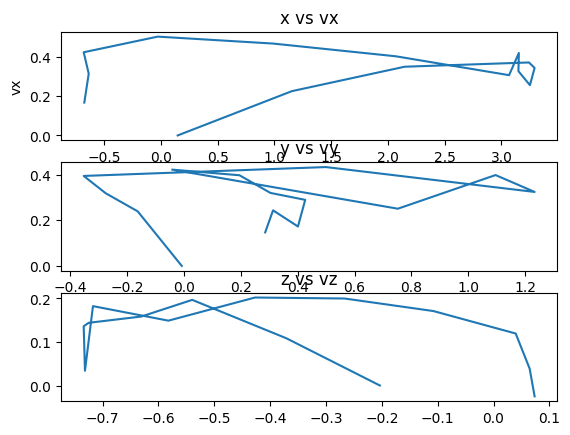

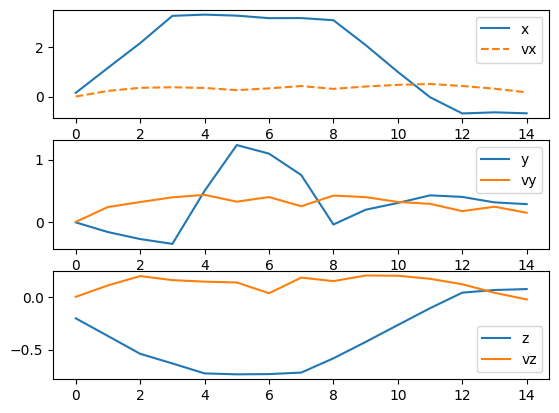

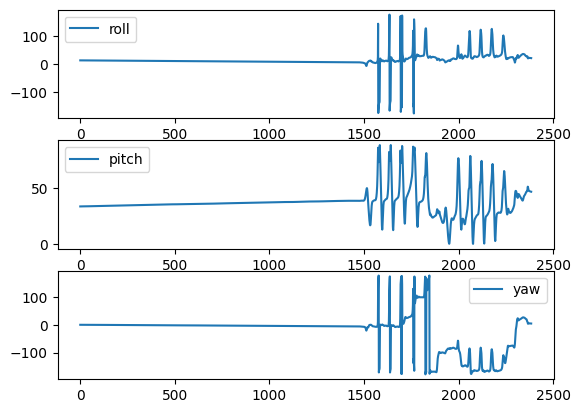

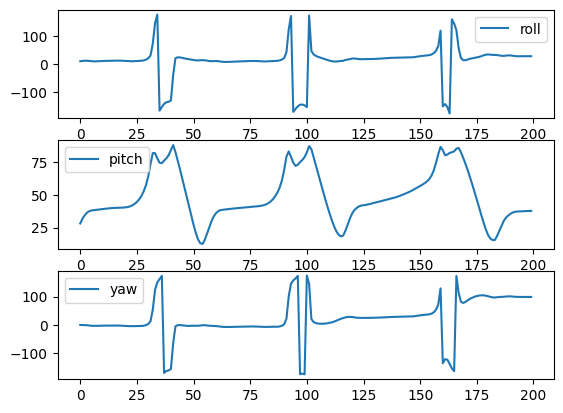

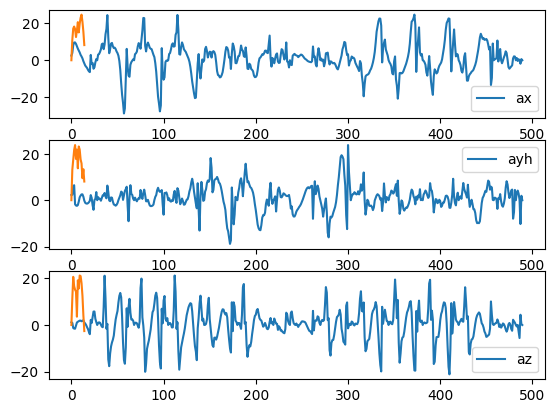

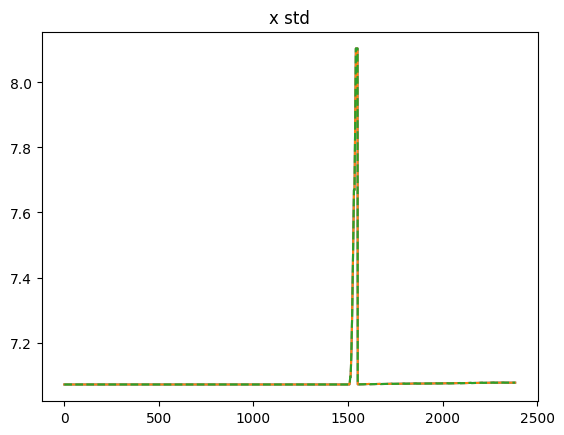

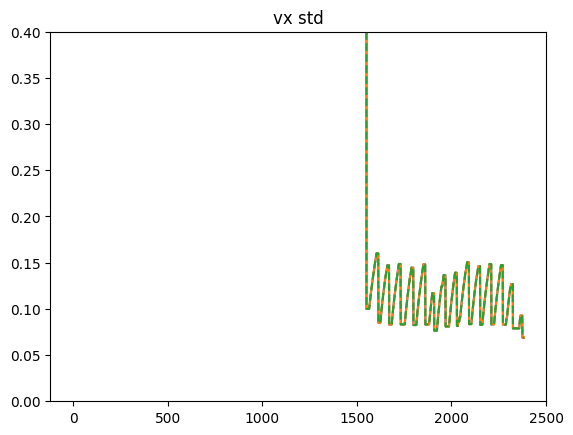

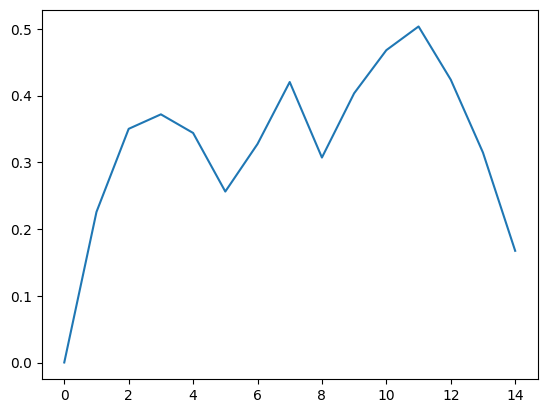

In [8]:
x=np.array(x_est)
P=np.array(s.P)
fig,ax=plt.subplots(3)
ax[0].plot(x[:,0],x[:,3])
ax[0].set_title('x vs vx')
ax[0].set_xlabel('x')
ax[0].set_ylabel('vx')

ax[1].plot(x[:,1],x[:,4])
ax[1].set_title('y vs vy')

ax[2].plot(x[:,2],x[:,5])
ax[2].set_title('z vs vz')
plt.show()

fig,ax=plt.subplots(3)
ax[0].plot(x[:,0])
ax[0].plot(x[:,3],'--')
ax[0].legend(['x','vx'])
ax[1].plot(x[:,1])
ax[1].plot(x[:,1+3])
ax[1].legend(['y','vy'])
ax[2].plot(x[:,2])
ax[2].plot(x[:,2+3])
ax[2].legend(['z','vz'])

plt.show()
ang=np.array(ang)
fig,ax=plt.subplots(3)
ax[0].plot(ang[:,0])
ax[0].legend(['roll'])

ax[1].plot(ang[:,1])
ax[1].legend(['pitch'])

ax[2].plot(ang[:,2])
ax[2].legend(['yaw'])
plt.show()

ind=[1600,1800]
fig,ax=plt.subplots(3)
ax[0].plot(ang[ind[0]:ind[1],0])

ax[0].legend(['roll'])
ax[1].plot(ang[ind[0]:ind[1],1])

ax[1].legend(['pitch'])
ax[2].plot(ang[ind[0]:ind[1],2])
ax[2].legend(['yaw'])
plt.show()

u=np.array(uu)
fig,ax=plt.subplots(3)
ax[0].plot(u[:,0])
# ax[0].plot(np.cumsum(u[:,0]*dt))
ax[0].plot(np.max(u[:,0])*x[:,0+3]/np.max(x[:,0+3]))
ax[0].legend(['ax'])

ax[1].plot(u[:,1])
ax[1].plot(np.max(u[:,1])*x[:,1+3]/np.max(x[:,1+3]))
# ax[1].plot(np.cumsum(u[:,1]*dt))
ax[1].legend(['ayh'])

ax[2].plot(u[:,2])
ax[2].plot(np.max(u[:,2])*x[:,2+3]/np.max(x[:,2+3]))
ax[2].legend(['az'])
plt.show()

plt.plot(np.sqrt(P[:,0,0]))
plt.plot(np.sqrt(P[:,1,1]))
plt.plot(np.sqrt(P[:,2,2]),'--')
plt.title('x std')
plt.show()
plt.plot(np.sqrt(P[:,3,3]))
plt.plot(np.sqrt(P[:,4,4]))
plt.plot(np.sqrt(P[:,5,5]),'--')
plt.ylim([0,0.4])
plt.title('vx std')
plt.show()

plt.plot(x[:,3])
plt.show()

## analisys
0. use saver
1. show every state and its covariance with update points with units!
2. show x\y vs vx\vy states and covariance with units!
3. show path with variance elipse 
4. show euler angles with units!


### states variance

### states variance and residuals 

### total errors